<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predecir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

--2022-11-14 19:51:01--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2022-11-14 19:51:01--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2022-11-14 19:51:01--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

### Se eligió como el TP anterior a la artista "Amy Winehouse", pero se suman mas canciones para umentar el dataset. 

In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['jimi-hendrix.txt',
 'michael-jackson.txt',
 'joni-mitchell.txt',
 'rihanna.txt',
 'al-green.txt',
 'lorde.txt',
 'dickinson.txt',
 'cake.txt',
 'notorious_big.txt',
 'dr-seuss.txt',
 'alicia-keys.txt',
 'amy-winehouse.txt',
 'radiohead.txt',
 'eminem.txt',
 'kanye-west.txt',
 'nirvana.txt',
 'bruce-springsteen.txt',
 'Lil_Wayne.txt',
 'disney.txt',
 'kanye.txt',
 'patti-smith.txt',
 'missy-elliott.txt',
 'paul-simon.txt',
 'beatles.txt',
 'britney-spears.txt',
 'bob-dylan.txt',
 'ludacris.txt',
 'prince.txt',
 'bjork.txt',
 'bruno-mars.txt',
 'notorious-big.txt',
 'leonard-cohen.txt',
 'Kanye_West.txt',
 'blink-182.txt',
 'nicki-minaj.txt',
 'r-kelly.txt',
 'lil-wayne.txt',
 'johnny-cash.txt',
 'bob-marley.txt',
 'bieber.txt',
 'adele.txt',
 'lin-manuel-miranda.txt',
 'dolly-parton.txt',
 'dj-khaled.txt',
 'nickelback.txt',
 'janisjoplin.txt',
 'lady-gaga.txt',
 'nursery_rhymes.txt',
 'drake.txt']

### Selección Amy Winehouse, Bruno Mars y britney-spears.txt

In [33]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df_1 = pd.read_csv('songs_dataset/amy-winehouse.txt', sep='/n', header=None)
df_2 = pd.read_csv('songs_dataset/bruno-mars.txt', sep='/n', header=None)
df_3 = pd.read_csv('songs_dataset/britney-spears.txt', sep='/n', header=None)
df = pd.concat([df_1, df_2, df_3], axis =0)
df.reset_index(drop=True, inplace=True)
df.head()

,0
0,Build your dreams to the stars above
1,But when you need someone to love
2,"Don't go to strangers, darling, come to me Pla..."
3,And when there's no place for you to turn
4,"Don't go to strangers, darling, come to me For..."


### Posee algunos documentos más que el ejemplo de los beatles

In [34]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 9028


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

### Se seleccionó secuencia de 5 palabras ya que en la musica hay varios conectores

In [35]:
from keras.preprocessing.text import Tokenizer # equivalente a tokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 5

In [36]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Build your dreams to the stars above'

In [37]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['build', 'your', 'dreams', 'to', 'the', 'stars', 'above']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [38]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [39]:
# Demos un vistazo
sentence_tokens[:2]

[['build', 'your', 'dreams', 'to', 'the', 'stars', 'above'],
 ['but', 'when', 'you', 'need', 'someone', 'to', 'love']]

In [40]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [41]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['build', 'your', 'dreams', 'to', 'the'],
 ['your', 'dreams', 'to', 'the', 'stars']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [42]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [43]:
# Ahora sequences tiene los números "ID", largo 5
sequences

[[5, 1, 2, 3, 4], [1, 2, 3, 4, 6]]

In [44]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

2


In [45]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

6


In [46]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'your': 1, 'dreams': 2, 'to': 3, 'the': 4, 'build': 5, 'stars': 6}


In [47]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'to': 2, 'dreams': 2, 'build': 1, 'the': 2, 'your': 2, 'stars': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [48]:
# Vistazo a las primeras 25 filas
df.loc[:25,0]

0                  Build your dreams to the stars above
1                     But when you need someone to love
2     Don't go to strangers, darling, come to me Pla...
3             And when there's no place for you to turn
4     Don't go to strangers, darling, come to me For...
5                       You'll follow your heart I know
6         I've been through it all, for I'm an old hand
7                      And I'll understand if you go So
8                Make your mark for your friends to see
9                   But when you need more than company
10    Don't go to strangers, darling, come to me Ton...
11                        You give your soul so sweetly
12            Tonight the light of love is in your eyes
13    Will you love me tomorrow Is this a lasting tr...
14                          Or just a moment's pleasure
15                Can I believe the magic of your sighs
16    Will you still love me tomorrow Tonight with w...
17         You said that I'm the only one, the o

In [49]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Build your dreams to the stars above But when you need someone to love Don\'t go to strangers, darling, come to me Play with fire till your fingers burn And when there\'s no place for you to turn Don\'t go to strangers, darling, come to me For, when you hear a call to follow your heart You\'ll follow your heart I know I\'ve been through it all, for I\'m an old hand And I\'ll understand if you go So Make your mark for your friends to see But when you need more than company Don\'t go to strangers, darling, come to me Tonight you\'re mine, completely You give your soul so sweetly Tonight the light of love is in your eyes Will you love me tomorrow Is this a lasting treasure Or just a moment\'s pleasure Can I believe the magic of your sighs Will you still love me tomorrow Tonight with words unspoken You said that I\'m the only one, the only one But will my heart be broken When the night meets the morning star I\'d like to know that your love Is a love I can be sure of So tell me now, \'cau

In [50]:
 # Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['build',
 'your',
 'dreams',
 'to',
 'the',
 'stars',
 'above',
 'but',
 'when',
 'you',
 'need',
 'someone',
 'to',
 'love',
 "don't",
 'go',
 'to',
 'strangers',
 'darling',
 'come']

In [51]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 70597


In [52]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [53]:
# Demos un vistazo a nuestros vectores para entrenar el modelo. Los 35 primeros.
text_sequences[:35]

[['build', 'your', 'dreams', 'to', 'the'],
 ['your', 'dreams', 'to', 'the', 'stars'],
 ['dreams', 'to', 'the', 'stars', 'above'],
 ['to', 'the', 'stars', 'above', 'but'],
 ['the', 'stars', 'above', 'but', 'when'],
 ['stars', 'above', 'but', 'when', 'you'],
 ['above', 'but', 'when', 'you', 'need'],
 ['but', 'when', 'you', 'need', 'someone'],
 ['when', 'you', 'need', 'someone', 'to'],
 ['you', 'need', 'someone', 'to', 'love'],
 ['need', 'someone', 'to', 'love', "don't"],
 ['someone', 'to', 'love', "don't", 'go'],
 ['to', 'love', "don't", 'go', 'to'],
 ['love', "don't", 'go', 'to', 'strangers'],
 ["don't", 'go', 'to', 'strangers', 'darling'],
 ['go', 'to', 'strangers', 'darling', 'come'],
 ['to', 'strangers', 'darling', 'come', 'to'],
 ['strangers', 'darling', 'come', 'to', 'me'],
 ['darling', 'come', 'to', 'me', 'play'],
 ['come', 'to', 'me', 'play', 'with'],
 ['to', 'me', 'play', 'with', 'fire'],
 ['me', 'play', 'with', 'fire', 'till'],
 ['play', 'with', 'fire', 'till', 'your'],
 ['with

In [54]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
# Token ---> integers
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[1776, 14, 421, 5, 3],
 [14, 421, 5, 3, 434],
 [421, 5, 3, 434, 323],
 [5, 3, 434, 323, 25],
 [3, 434, 323, 25, 34],
 [434, 323, 25, 34, 1],
 [323, 25, 34, 1, 80],
 [25, 34, 1, 80, 307],
 [34, 1, 80, 307, 5],
 [1, 80, 307, 5, 37],
 [80, 307, 5, 37, 26],
 [307, 5, 37, 26, 42],
 [5, 37, 26, 42, 5],
 [37, 26, 42, 5, 757],
 [26, 42, 5, 757, 394],
 [42, 5, 757, 394, 55],
 [5, 757, 394, 55, 5],
 [757, 394, 55, 5, 4],
 [394, 55, 5, 4, 422],
 [55, 5, 4, 422, 36]]

In [55]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 70592


### 3 - Input y target

In [56]:
# Con numpy es muy fácil realizar el slicing de vectores
# Elejimos 5 words
ex = np.array([[1,2,3,4,5],[5,6,7,8,9]])
ex

array([[1, 2, 3, 4, 5],
       [5, 6, 7, 8, 9]])

In [57]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 5)
Todos los elementos: [[1 2 3 4 5]
 [5 6 7 8 9]]
Todos los elementos menos el último: [[1 2 3 4]
 [5 6 7 8]]


In [58]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3 4]
 [5 6 7 8]]
Target: [5 9]


In [59]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(70592, 4)
(70592,)


In [60]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'me',
 5: 'to',
 6: 'my',
 7: 'and',
 8: 'it',
 9: 'a',
 10: 'oh',
 11: 'in',
 12: "i'm",
 13: 'on',
 14: 'your',
 15: 'so',
 16: 'baby',
 17: 'all',
 18: 'that',
 19: 'like',
 20: 'just',
 21: 'for',
 22: 'yeah',
 23: 'know',
 24: 'what',
 25: 'but',
 26: "don't",
 27: 'be',
 28: 'we',
 29: 'up',
 30: 'is',
 31: 'of',
 32: 'get',
 33: 'do',
 34: 'when',
 35: 'got',
 36: 'with',
 37: 'love',
 38: 'now',
 39: "you're",
 40: 'no',
 41: "it's",
 42: 'go',
 43: 'can',
 44: 'this',
 45: 'want',
 46: 'if',
 47: 'out',
 48: 'girl',
 49: 'see',
 50: 'take',
 51: 'her',
 52: 'not',
 53: 'are',
 54: 'more',
 55: 'come',
 56: "'cause",
 57: 'time',
 58: 'she',
 59: 'gimme',
 60: 'make',
 61: 'let',
 62: "can't",
 63: 'wanna',
 64: 'one',
 65: 'will',
 66: 'way',
 67: 'tell',
 68: 'here',
 69: 'down',
 70: 'feel',
 71: 'la',
 72: 'never',
 73: 'ooh',
 74: 'was',
 75: "that's",
 76: 'at',
 77: 'have',
 78: 'say',
 79: 'work',
 80: 'need',
 81: 'from',
 82: "i'll",

In [61]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3477

In [62]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: ignored

In [63]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [64]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(70592, 3477)

### 4 - Entrenar el modelo

In [65]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

4

In [66]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3477

### Se modifica la arquitectura colocando una capa más con su "dropout" 

In [78]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5)) #Aumento el dropout 
# Colocamos una capa más
#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 4, 5)              17390     
                                                                 
 lstm_4 (LSTM)               (None, 4, 64)             17920     
                                                                 
 dropout_2 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3477)              114741    
                                                                 
Total params: 185,155
Trainable params: 185,155
Non-tr

In [79]:
hist = model.fit(x_data, y_data, epochs=150, validation_split=0.2)

Epoch 1/150
1765/1765 [==============================] - 19s 9ms/step - loss: 6.1984 - accuracy: 0.0432 - val_loss: 6.2439 - val_accuracy: 0.0442
Epoch 2/150
1765/1765 [==============================] - 15s 8ms/step - loss: 5.8618 - accuracy: 0.0489 - val_loss: 6.1739 - val_accuracy: 0.0497
Epoch 3/150
1765/1765 [==============================] - 15s 9ms/step - loss: 5.5792 - accuracy: 0.0577 - val_loss: 6.2021 - val_accuracy: 0.0522
Epoch 4/150
1765/1765 [==============================] - 15s 8ms/step - loss: 5.3913 - accuracy: 0.0666 - val_loss: 6.2138 - val_accuracy: 0.0519
Epoch 5/150
1765/1765 [==============================] - 15s 9ms/step - loss: 5.2172 - accuracy: 0.0784 - val_loss: 6.2307 - val_accuracy: 0.0662
Epoch 6/150
1765/1765 [==============================] - 16s 9ms/step - loss: 5.0596 - accuracy: 0.0881 - val_loss: 6.3391 - val_accuracy: 0.0703
Epoch 7/150
1765/1765 [==============================] - 15s 8ms/step - loss: 4.9219 - accuracy: 0.0967 - val_loss: 6.4130 -

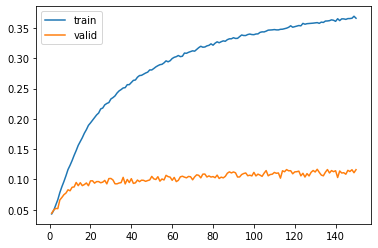

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [81]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [82]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

### Se utilizarán frases de "Amy Winehouse" de su canción emblematica "Back To Black" para corroborar las predicciones, en este caso de 4+1 palabras incluida la a predecir. Esto es por que en las canciones se utilizan muchos conectores.

In [83]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=4, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().

Using Embedded Colab Mode (NEW). If you have issues, please use share=True and file an issue at https://github.com/gradio-app/gradio/
Note: opening the browser inspector may crash Embedded Colab Mode.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 1s 623ms/step
Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f1694f6ae10>, 'http://127.0.0.1:7860/', None)

### 6 - Generación de secuencias nuevas

In [85]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [93]:
input_text='You go back to'

generate_seq(model, tok, input_text, max_length=5, n_words=3)

1/1 [==============================] - 0s 18ms/step


'You go back to destiny you alive'

### 7 - Conclusiones
El modelo entrenado tuvo un desempeño acorde al dataset cercano a 9000 palabras. En el entrenamiento se llego a un overfitting, el cuál se trató de reducir con "dropout" = 0.5. Se trató de mejorar con:
- Agregar más capas o neuronas (solo empeoró el "accuracy")
- Incrementar la cantidad de épocas (mejoró el "accuracy")
- Agregar BRNN

Como creamos nuestros propios embeddings, se aumento el dataset con 2 artistas más Bruno Mars y Brtney Spears.